# Table of Contents

1. [Data Cleaning, Preprocessing and Parametrization](#datacleaning)
2. [ABM Model](#prediction)       
3. [Conclusions and further improvements](#theend)
    1. [Directed graph](#dirgraph)

In [2]:
#importing necessary packages

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from scipy.integrate import odeint
import networkx as nx


# Data Cleaning, Preprocessing and Parametrization <a name="datacleaning"></a>

In the following cells we are going to import and pre-process our data. Plus, we will be computing the model parameters. Besides the Betas and Gammas mentioned in the paper, we also tried different weighted procedures using two further inputs: the Derivetives' exposure and the GDP of each country. The aim was to try different weighting procedures, yet we decided to stick to the definition of "ultimate financial risk" explained in the paper. Nevertheless, we kept our computation in this notebook.

The way we computed all the parameters and weights is the following:

- Beta coefficients:

$$β_i= \frac{α_{i}}{\sum_{j=1}^{23}α_{j}}$$

where $α_{ij}$ is the claims exposure of country i towards country j.

- Gamma coefficients:

$$ɣ_i= \frac{1}{101-C_i}$$

where $C_i$ is the numeric risk score attributed to that country: the higher the risk, the higher the recovery time from the crisis.

- Weighted Betas with derivatives

$$β_i= \frac{α_{i}}{\sum_{j=1}^{23}α_{ij}}*w_i$$

where $w_i$ is proportional to the derivative exposure of country i.


- Inverse score: once we computed the normalized weights from the GDP of each country, we computed the inverse score as follows:


$$score_i= \frac{1}{\sum_{j=1}^{23}w_j}$$

where $w_i$ is the normalized GDP ($w_i= \frac{GDP_i}{\sum_{j=1}^{23}GDP_j}$) of country i. The *ratio* is that the higher the GDP, the less risky the country is. Of course those scores are normalized before being used, so that they sum up to 1.

In [6]:
#run this cell to obtain the final dataset

df = pd.read_excel('data/table-b3-s.xlsx')[['Unnamed: 0', 'Foreign Claims', 'Derivatives']].rename(columns = {'Unnamed: 0': 'Country'}).iloc[0:24]
scores = pd.read_excel("data/new credit score.xlsx").rename(columns = {'Unnamed: 0': 'Country'})
countries = []
for i in range(len(scores)):
    countries.append(scores['Country'][i])
    
countries[countries.index('South Korea')] = 'Korea'
scores['Country']=countries

mask = [i in df['Country'].unique() for i in scores['Country']]
scores = scores[mask]

#removing Chinese Taipei from df since there is no corresponding scoring.
df=df.set_index('Country', drop=True)
df = df.drop('Chinese Taipei', axis=0)
assert len(df) == len(scores)
df=df.reset_index(drop=False)

final_df = df.merge(scores, how='inner', left_on='Country', right_on='Country')[['Country', 'Foreign Claims', 'Derivatives', 'Numeric Value']].set_index('Country', drop=True)


#len(countries)

#data cleaning, merging and preprocessing. Skip this cell and run to the next one to directly obtain the final dataset

df_w = pd.read_excel('data/API_NY.GDP.MKTP.CD_DS2_en_excel_v2_935893.xls')
ind = df_w.index[df_w['Country Name'] == 'Korea, Rep.']
df_w.at[ind[0], 'Country Name'] = 'Korea'
df_w=df_w.rename(columns={'GDP ': 'GDP'}).reset_index(drop=True)
df_w.head()

#picking only those 23 countries we are interested in
mask = [i in final_df.index for i in df_w['Country Name']]
df_w = df_w[mask]
df_w = df_w.reset_index(drop=True)



#computing weights

s = df_w['GDP'].sum()
w = []
for i in range(len(df_w)):
    w.append(df_w['GDP'][i]/s)
    
df_w['Weighted scores']=w
df_w = df_w.drop('Weighet score', axis = 1)

#computing inverse scores, since the higher the GDP, the less risky the country is

tmp = []
for i in range(len(df_w)):
    w = 1/df_w['Weighted scores'][i]
    tmp.append(w)
    
df_w['tmp'] = tmp

inv_w = []
s = sum(df_w['tmp'])
for i in range(len(df_w)):
    inv = df_w['tmp'][i]/s
    inv_w.append(inv)

df_w['Inverse score'] = inv_w
df_w = df_w.drop('tmp', axis = 1)

#sum(df_w['Inverse score']) to assert whether it sums up to 1


#merging the final_df with this df_w
df_w = df_w.merge(final_df, left_on = 'Country Name', 
           right_index=True).drop(['GDP', 'Weighted scores'], 
                                  axis = 1).rename(columns = {'Numeric Value': 'Credit Score'})


final_df = df_w.sort_values(by = 'Country Name', ascending = True).reset_index(drop=True)



#computing betas and gammas

betas = []
weighted_betas = [] #weighted by Derivatives
tot_claims = final_df['Foreign Claims'].sum()
tot_derivatives = final_df['Derivatives'].sum()

for i in range(len(final_df)):
      weight = final_df['Derivatives'][i]/tot_derivatives
      num = final_df['Foreign Claims'][i]
      betas.append(num/tot_claims)
      weighted_betas.append((num/tot_claims)*weight)
    
weighted_betas = [float(i)/sum(weighted_betas) for i in weighted_betas]
#sum(weighted_betas)==1.0

gammas = []
for i in range(len(final_df)):
    gammas.append(1/(101-final_df['Credit Score'][i]))
#gammas

final_df['betas'] = betas
final_df['gammas'] = gammas
final_df['weighted betas'] = weighted_betas


#storing results
final_df.to_pickle("final_df.pkl")

,Foreign Claims,Derivatives,Numeric Value
Country,,,
Australia,687.6,55.5,100.0
Austria,391.2,20.4,95.0
Belgium,233.5,32.7,90.0
Canada,1897.9,115.3,100.0
Chile,14.2,2.6,80.0


In [3]:
#run this cell to download results
final_df = pd.read_pickle("final_df.pkl")
final_df

,Country Name,Inverse score,Foreign Claims,Derivatives,Credit Score,betas,gammas,weighted betas
0,Australia,0.019712,687.6,55.5,100.0,0.025719,1.000000,0.006623
1,Austria,0.062082,391.2,20.4,95.0,0.014632,0.166667,0.001385
2,Belgium,0.052077,233.5,32.7,90.0,0.008734,0.090909,0.001325
3,Canada,0.016497,1897.9,115.3,100.0,0.070988,1.000000,0.037976
4,Chile,0.094776,14.2,2.6,80.0,0.000531,0.047619,0.000006
5,Finland,0.102135,472.9,58.3,95.0,0.017688,0.166667,0.004785
6,France,0.010176,3098.6,146.5,90.0,0.115899,0.090909,0.078780
7,Germany,0.007160,1873.4,695.3,100.0,0.070072,1.000000,0.226055
8,Greece,0.129638,57.7,1.0,40.0,0.002158,0.016393,0.000010
9,India,0.010396,85.6,58.9,55.0,0.003202,0.021739,0.000875


Let's inspect the interaction between gammas and betas: we are expecting high betas to correspond to low gammas and vice-versa.

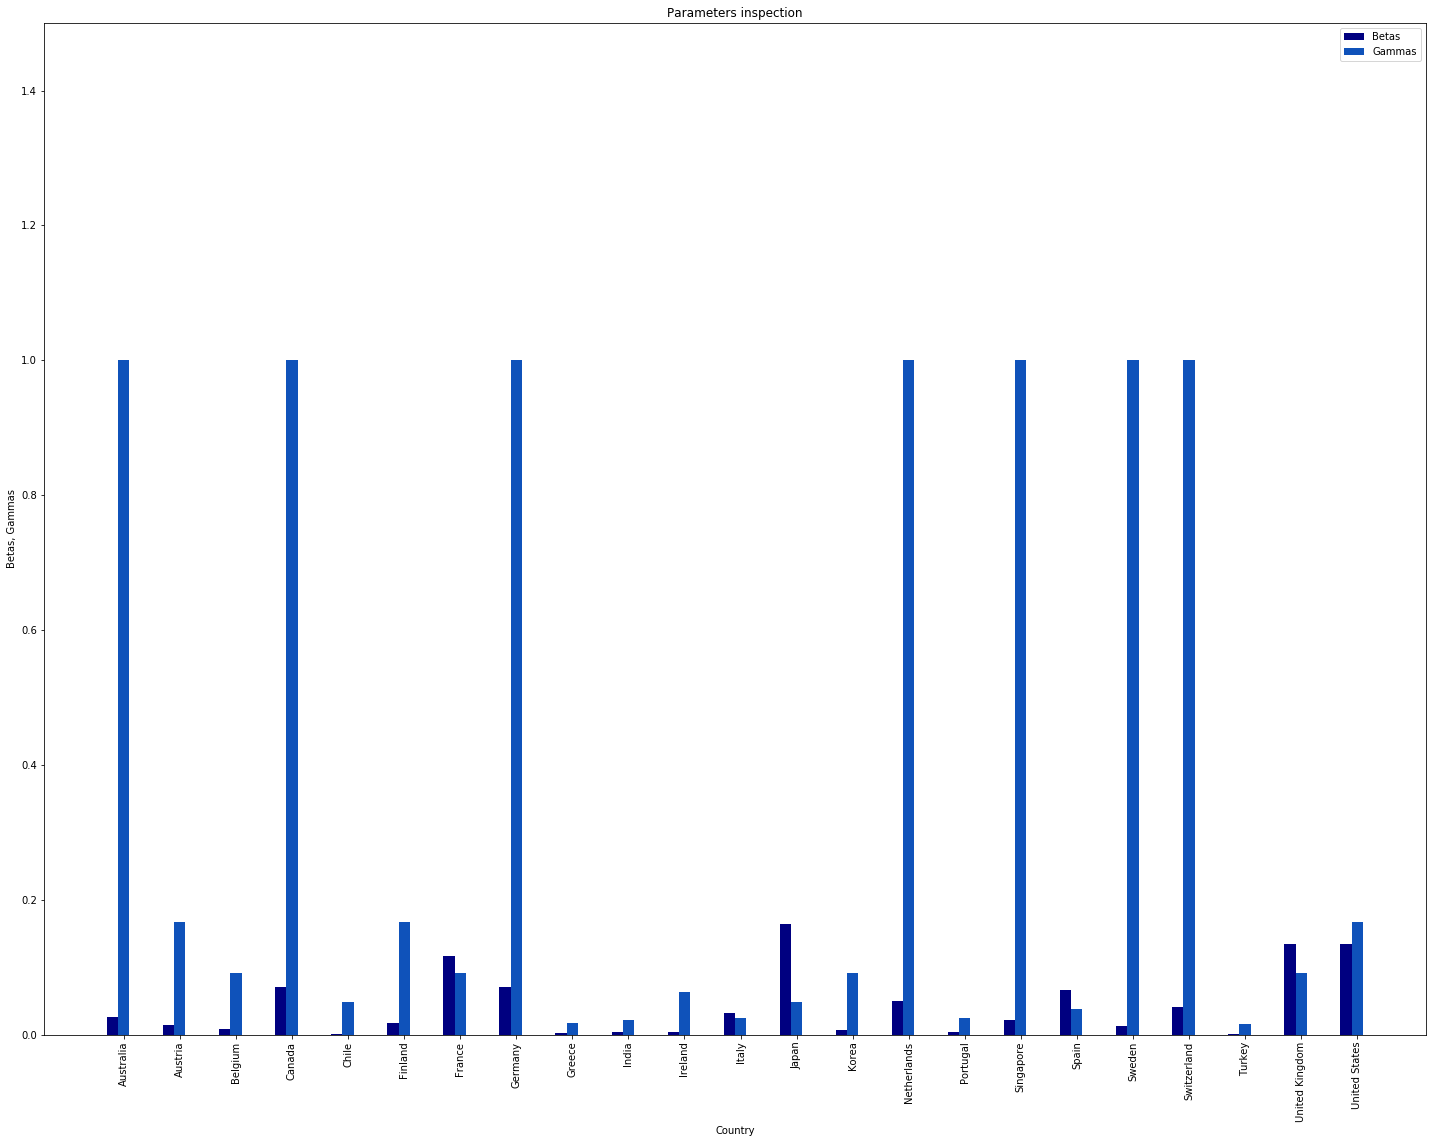

In [14]:
countries = [i for i in final_df['Country Name']]

import numpy as np
import matplotlib.pyplot as plt

data = np.zeros(len(countries)*2).reshape(len(countries), 2)
for i in range(len(final_df)):
    data[i][0] = final_df['betas'][i]
    data[i][1] = final_df['gammas'][i]
    



length = len(countries)
x_labels = countries

# Set plot parameters
fig = plt.figure(figsize=(20,15))
ax = plt.subplot(111)
width = 0.2 # width of bar
x = np.arange(length)

ax.bar(x, data[:,0], width, color='#000080', label='Betas')
ax.bar(x + width, data[:,1], width, color='#0F52BA', label='Gammas')


ax.set_ylabel('Betas, Gammas')
ax.set_ylim(0,1.5)
ax.set_xticks(x + width)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Country')
ax.set_title('Parameters inspection')
ax.legend()
#plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

fig.tight_layout()
plt.xticks(rotation='vertical')
plt.show()

# Agent Based Model <a name="prediction"></a>

In [3]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

import math
from enum import Enum

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid

G = nx.read_gpickle("G_caseA") #nx.read_gpickle("G_caseA.dms") 
final_df = pd.read_pickle("final_df.pkl")

# Adding labels
countries = list(final_df['Country Name'])
labels={}
for i in range(len(countries)):
    labels[countries[i]] = countries[i]

In [4]:
final_df = final_df.set_index('Country Name')

In [5]:
def bootstrapping_CI(df):
    means = []
    CI_upper = []
    CI_lower = []
    for i in range(len(df.columns)):
        CI = bs.bootstrap(df.iloc[:,i].to_numpy(), stat_func=bs_stats.mean)
        avg = df.iloc[:,i].mean()
        means.append(avg)
        CI_upper.append(CI.upper_bound)
        CI_lower.append(CI.lower_bound)
    return means, CI_upper, CI_lower

## Model & Calculations

In [6]:
result_dataframe = pd.DataFrame()

Australia


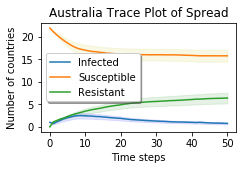

Austria


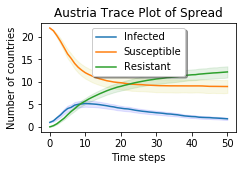

Belgium


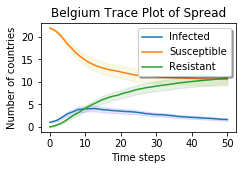

Canada


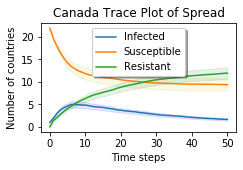

Chile


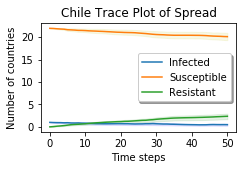

Finland


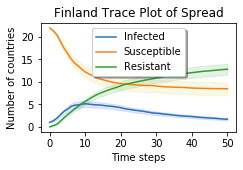

France


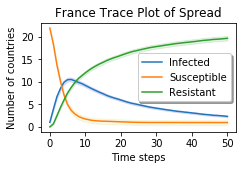

Germany


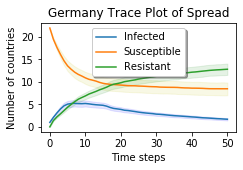

Greece


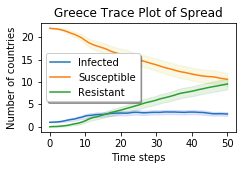

India


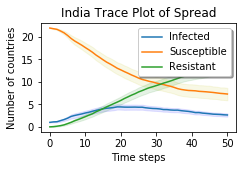

Ireland


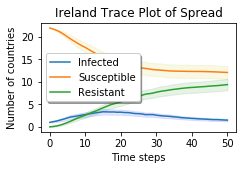

Italy


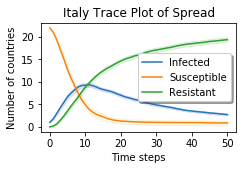

Japan


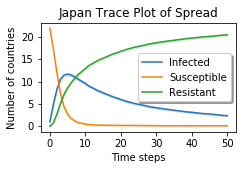

Korea


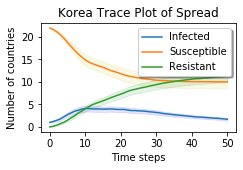

Netherlands


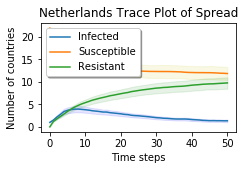

Portugal


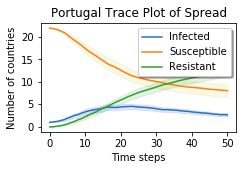

Singapore


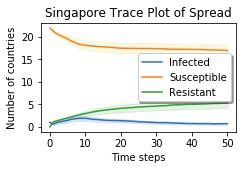

Spain


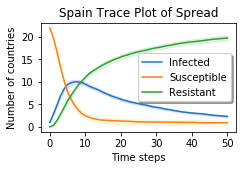

Sweden


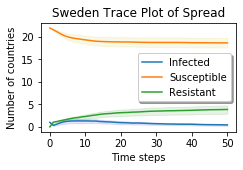

Switzerland


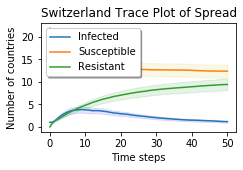

Turkey


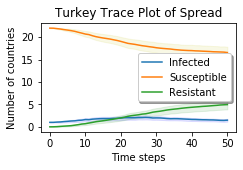

United Kingdom


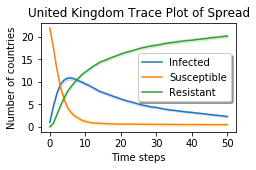

United States


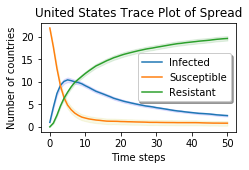

In [7]:
for starting_point in G.nodes():
    print(starting_point)
    # Parameters for the model
    final_df  = final_df
    Graph = G
    country = starting_point
    outbreak_size = 1
    printing = False
    
    # Model
    class State(Enum):
        SUSCEPTIBLE = 0
        INFECTED = 1
        RESISTANT = 2

    def number_state(model, state):
        return sum([1 for a in model.grid.get_all_cell_contents() if a.state is state])

    def list_state(model,state):
        lister =  [a for a in model.grid.get_all_cell_contents() if a.state is state]
        return [a.unique_id for a in lister]


    def number_infected(model):
        return number_state(model, State.INFECTED)

    def number_susceptible(model):
        return number_state(model, State.SUSCEPTIBLE)

    def number_resistant(model):
        return number_state(model, State.RESISTANT)


    def list_infected(model):
        return list_state(model, State.INFECTED)

    def list_susceptible(model):
        return list_state(model, State.SUSCEPTIBLE)

    def list_resistant(model):
        return list_state(model, State.RESISTANT)

    # Measuring severity of the network
    def resistant_susceptible_ratio(model):
        try:
            return number_state(model, State.RESISTANT) / number_state(model, State.SUSCEPTIBLE)
        except ZeroDivisionError:
            return np.nan

    def infected_susceptible_ratio(model):
        try:
            return number_state(model, State.INFECTED) / number_state(model, State.SUSCEPTIBLE)
        except ZeroDivisionError:
            return np.nan

    def infected_resistant_ratio(model):
        try:
            return number_state(model, State.INFECTED) / number_state(model, State.RESISTANT)
        except ZeroDivisionError:
            return np.nan


    class VirusOnNetwork(Model):
        def __init__(self, initial_outbreak_size=outbreak_size, 
                     final_df = final_df, 
                     outbreak_country = country,
                     printing = printing):
            self.G = Graph
            self.grid = NetworkGrid(self.G)
            self.outbreak_country = country
            self.final_df = final_df
            self.schedule = RandomActivation(self)
            self.initial_outbreak_size = initial_outbreak_size
            self.unique_id_store  = {}
            self.printing = printing

            # Create agents
            #unique_id_store
            for i, node in enumerate(self.G.nodes()):
                prob_infect = self.final_df.loc[node,'betas']
                prob_recovery = self.final_df.loc[node,'gammas']
                a = VirusAgent(i, self, State.SUSCEPTIBLE, prob_infect, prob_recovery, self.unique_id_store, self.printing)
                self.schedule.add(a)
                self.unique_id_store[a.unique_id] = node
                if self.printing == True:
                    print(f'Adding agent:{node}. Beta: {prob_infect}, Gamma: {prob_recovery}')
                # Add the agent to the node
                self.grid.place_agent(a, node)

            # Infect some nodes
            infected_nodes = [str(self.outbreak_country)]
            if self.printing == True:
                print(f"First infected country {infected_nodes}")
            for a in self.grid.get_cell_list_contents(infected_nodes):
                a.state = State.INFECTED

            self.datacollector = DataCollector({"Infected": number_infected,
                                                "List_I": list_infected,
                                                "Susceptible": number_susceptible,
                                                "List_S": list_susceptible,
                                                "Resistant": number_resistant,
                                                "List_R": list_resistant,
                                                "resistant_susc_ratio": resistant_susceptible_ratio,
                                                "infected_susc_ratio": infected_susceptible_ratio,
                                                "infected_resistant_ratio": infected_resistant_ratio
                                               })    

            self.running = True
            self.datacollector.collect(self)

        def step(self):
            self.schedule.step()
            # collect data
            self.datacollector.collect(self)

        def run_model(self, n):
            for i in range(n):
                self.step()

    class VirusAgent(Agent):
        def __init__(self, unique_id, model, initial_state, prob_infect, prob_recovery, unique_id_store, printing):
            super().__init__(unique_id, model)
            self.state = initial_state
            self.prob_infect = prob_infect
            self.prob_recovery = prob_recovery
            self.unique_id_store = unique_id_store
            self.printing = printing

        def try_to_infect_neighbors(self):
            neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
            susceptible_neighbors = [agent for agent in self.model.grid.get_cell_list_contents(neighbors_nodes) 
                                 if agent.state is State.SUSCEPTIBLE]

            # making sure all countries are reached
            assert len(neighbors_nodes) == len(model.G) - model.initial_outbreak_size 
            for a in susceptible_neighbors:            
                if self.random.random() < self.prob_infect:
                    a.state = State.INFECTED
                    unique_id = a.unique_id
                    if self.printing == True:
                        print(f"Infected:{self.unique_id_store[unique_id]}")

        def try_gain_resistance(self):
            if self.random.random() < self.prob_recovery:
                self.state = State.RESISTANT

        def try_check_situation(self):
            if self.state is State.INFECTED:
                self.try_gain_resistance()

        def step(self):
            if self.state is State.INFECTED:
                  self.try_to_infect_neighbors()

            self.try_check_situation()
            
    
    # Calling the model & cleaning
    model = VirusOnNetwork(initial_outbreak_size=outbreak_size, 
                       final_df = final_df, 
                       outbreak_country = country,
                       printing = printing)
    id_store = model.unique_id_store
    
    
    for i in range(50):
        model.step()
        
        
    data = model.datacollector.get_model_vars_dataframe()
    
    def cleaning(column):
        return [id_store[i] for i in column]
    
    data.List_I = data.List_I.apply(cleaning)
    data.List_S = data.List_S.apply(cleaning)
    data.List_R = data.List_R.apply(cleaning)
    
    # Generating simulations and saving results
    result_dict = {}
    
    data_store = {}
    num_simu = 200
    length_sim = 50
    for i in range(num_simu):
        model = VirusOnNetwork(initial_outbreak_size=outbreak_size, 
                           final_df = final_df, 
                           outbreak_country = country,
                           printing = printing)
        id_store = model.unique_id_store
        for j in range(length_sim):
            model.step()
        data = model.datacollector.get_model_vars_dataframe()

        # Metrics
        time_peak = data.Infected.idxmax()



        data_store[i] = [data.loc[:,['Infected', 'Susceptible', 'Resistant']], 
                         time_peak, 
                         data.loc[:,['resistant_susc_ratio', 'infected_susc_ratio', 'infected_resistant_ratio']]
                        ]
    # Data 
    InfectedDF = pd.DataFrame()
    SusceptibleDf = pd.DataFrame()
    ResistantDF = pd.DataFrame()
    # Ratios
    R_S_ratio = pd.DataFrame()
    I_S_ratio = pd.DataFrame()
    I_R_ratio = pd.DataFrame()
    # Metrics
    time_peak_list = []

    for k,v in data_store.items():
        df = v[0]
        time_peak = v[1]
        ratios = v[2]

        InfectedDF = InfectedDF.append(df.Infected)
        SusceptibleDf = SusceptibleDf.append(df.Susceptible)
        ResistantDF = ResistantDF.append(df.Resistant)

        time_peak_list.append(time_peak)

        R_S_ratio = R_S_ratio.append(ratios.resistant_susc_ratio)
        I_S_ratio = I_S_ratio.append(ratios.infected_susc_ratio)
        I_R_ratio = I_R_ratio.append(ratios.infected_resistant_ratio)


    InfectedDF.reset_index(inplace = True, drop = True)
    SusceptibleDf.reset_index(inplace = True, drop = True)
    ResistantDF.reset_index(inplace = True, drop = True)

    R_S_ratio.reset_index(inplace = True, drop = True)
    I_S_ratio.reset_index(inplace = True, drop = True)
    I_R_ratio.reset_index(inplace = True, drop = True)


    assert len(time_peak_list) == num_simu
    
    # Mean over each simulation of each state and then over all states
    result_dict['mean_R_S_ratio'] = R_S_ratio.mean().mean()
    result_dict['mean_I_S_ratio'] = I_S_ratio.mean().mean()
    result_dict['mean_I_R_ratio'] = I_R_ratio.mean().mean()
    
    # Bootstrapping: I & S & R time series
    meansI, CI_upperI, CI_lowerI = bootstrapping_CI(InfectedDF)
    meansS, CI_upperS, CI_lowerS = bootstrapping_CI(SusceptibleDf)
    meansR, CI_upperR, CI_lowerR = bootstrapping_CI(ResistantDF)

    assert CI_upperI > CI_lowerI
    assert CI_upperS > CI_lowerS
    assert CI_upperR > CI_lowerR 
    
    f, (ax) = plt.subplots(1, 1, figsize=(3.5,2))

    ax.plot(data.index, meansI, label='Infected')
    ax.fill_between(data.index, CI_upperI, CI_lowerI, color='b', alpha=.1)
    ax.plot(data.index, meansS, label='Susceptible')
    ax.fill_between(data.index, CI_upperS, CI_lowerS, color='y', alpha=.1)
    ax.plot(data.index, meansR, label='Resistant')
    ax.fill_between(data.index, CI_upperR, CI_lowerR, color='g', alpha=.1)
    ax.set_title(country + ' Trace Plot of Spread')
    ax.set_ylabel('Number of countries')
    ax.set_xlabel('Time steps')

    legend = ax.legend(loc='best', shadow=True)
    
    plt.show()
    

    # Infected
    result_dict['max_mean_Infected'] = max(meansI)
    result_dict['mean_Infected_t_10'] = meansI[9]
    result_dict['mean_Infected_t_30'] = meansI[29]
    result_dict['mean_Infected_t_50'] = meansI[49]

    # Susceptible
    result_dict['mean_Susceptible_t_10'] = meansS[9]
    result_dict['mean_Susceptible_t_30'] = meansS[29]
    result_dict['mean_Susceptible_t_50'] = meansS[49]

    # Resistant
    result_dict['max_mean_Resistant'] = max(meansR)
    result_dict['mean_Resistant_t_10'] = meansR[9]
    result_dict['mean_Resistant_t_30'] = meansR[29]
    result_dict['mean_Resistant_t_50'] = meansR[49]
    
    # Time to peak
    result_dict['Time_Peak_Infected_avg'] = np.mean(time_peak_list)
    
    # First Differences: 
    first_diff_I = pd.Series(np.diff(meansI))
    first_diff_S = pd.Series(np.diff(meansS))
    first_diff_R = pd.Series(np.diff(meansR))

    result_dict['mean_Infected_size_steepest_increase'] = first_diff_I.max()
    result_dict['mean_Infected_size_t_steepest_increase'] = first_diff_I.idxmax()

    result_dict['mean_Susceptible_size_steepest_decrease'] = first_diff_S.min()
    result_dict['mean_Susceptible_size_t_steepest_increase'] = first_diff_S.idxmin()

    result_dict['mean_Resistant_size_steepest_increase'] = first_diff_R.max()
    result_dict['mean_Resistant_size_t_steepest_increase'] = first_diff_R.idxmax()
    
    result_dict['country'] = starting_point
    
    result_dataframe = result_dataframe.append(result_dict, ignore_index = True)

In [8]:
result_dataframe.set_index('country', inplace = True)
result_dataframe.head(2)

,Time_Peak_Infected_avg,max_mean_Infected,max_mean_Resistant,mean_I_R_ratio,mean_I_S_ratio,mean_Infected_size_steepest_increase,mean_Infected_size_t_steepest_increase,mean_Infected_t_10,mean_Infected_t_30,mean_Infected_t_50,...,mean_Resistant_size_steepest_increase,mean_Resistant_size_t_steepest_increase,mean_Resistant_t_10,mean_Resistant_t_30,mean_Resistant_t_50,mean_Susceptible_size_steepest_decrease,mean_Susceptible_size_t_steepest_increase,mean_Susceptible_t_10,mean_Susceptible_t_30,mean_Susceptible_t_50
country,,,,,,,,,,,,,,,,,,,,,
Australia,2.94,2.505,6.420,0.199465,0.267899,0.415,1.0,2.495,1.325,0.79,...,1.115,0.0,3.270,5.63,6.395,-0.83,0.0,17.235,16.045,15.815
Austria,6.30,5.205,12.225,0.433956,0.643057,0.790,3.0,5.105,3.230,1.85,...,0.780,4.0,5.295,10.53,12.165,-1.42,4.0,12.600,9.240,8.985


#### Spread of the crisis

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

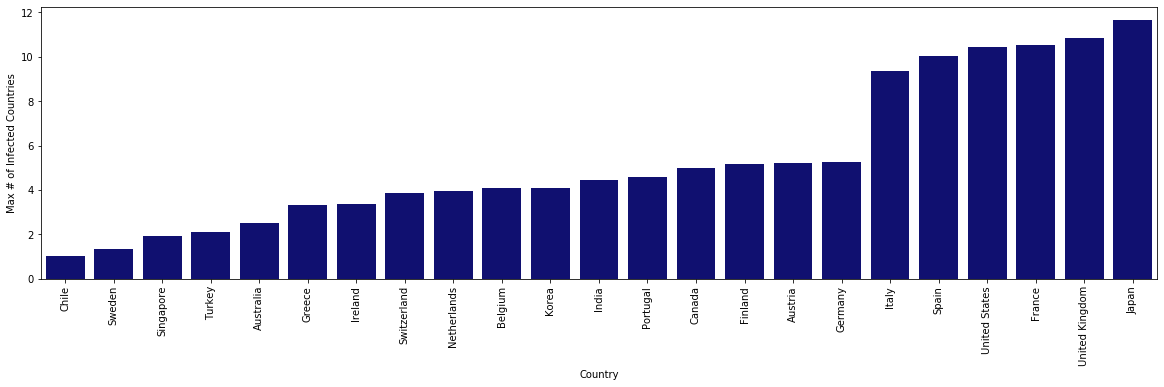

In [9]:
result_dataframe['country'] = result_dataframe.index
result_dataframe = result_dataframe.sort_values(by = ['max_mean_Infected'])
f, (ax) = plt.subplots(1, 1, figsize=(20,5))
ax = sns.barplot(x="country", y="max_mean_Infected", data=result_dataframe, color = "navy")
ax.set(xlabel='Country', ylabel='Max # of Infected Countries')
plt.setp(ax.get_xticklabels(), rotation=90)

#### Speed of the crisis

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

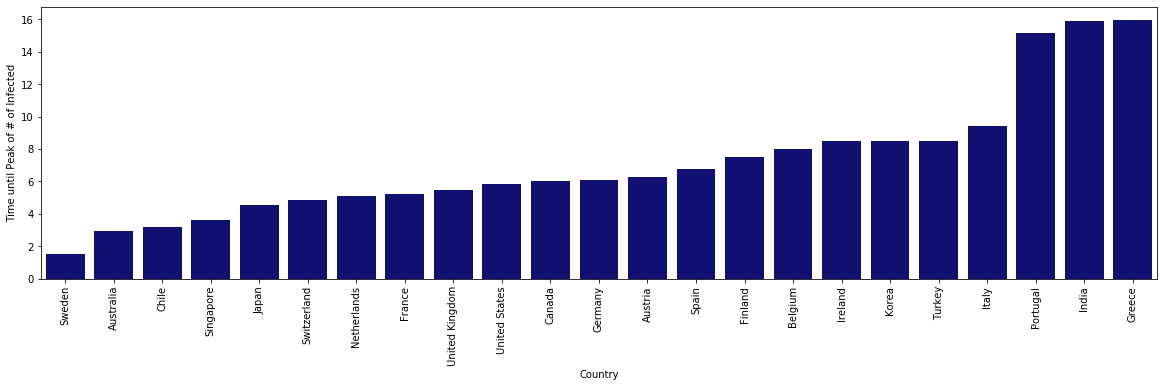

In [10]:
result_dataframe = result_dataframe.sort_values(by = ['Time_Peak_Infected_avg'])

f, (ax) = plt.subplots(1, 1, figsize=(20,5))
ax = sns.barplot(x="country", y="Time_Peak_Infected_avg", data=result_dataframe, color = "navy")
ax.set(xlabel='Country', ylabel='Time until Peak of # of Infected')
plt.setp(ax.get_xticklabels(), rotation=90)

# Conclusions and further improvements <a name="theend"></a>

During this analysis, we asked ourselves several questions about possible improvements of the model, which we didn't include in the final paper since not fully developed. 
Nevertheless, we decided to add a paragraph about those improvements. In particular, we are going to dwell on two extentions:

- Modeling the disease spreading with a directed network
- Modeling interventions in the field of SIR homogeneous model (this part will be mentioned in the paper)


## Directed graph <a name="dirgraph"></a>

The aim of this improvement was modeling not only the starting country of a crisis, but also the "direction" of this crisis. The idea was that we might have different betas for an edge connecting country A to B and the one connecting B to A.
Indeed, in a undirected graph, if the crisis starts from country A, we have that the "bond" between A and B is fixed, regardless of the crisis starting from A or B. On the other hand, if we allows two directions between A and B, a crisis starting from A (B) will not have the same impact on B (A) as B (A) would have had on A (B), had the crisis started in B (A).

Let's have a visual representation of that:

C:\Users\valen\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\valen\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


{'Australia': Text(0.96749175, 0.9797002, 'Australia'),
 'Austria': Text(0.87904406, 0.3656172, 'Austria'),
 'Belgium': Text(0.9579398, 0.67584693, 'Belgium'),
 'Canada': Text(0.6272638, 0.30780286, 'Canada'),
 'Chile': Text(0.85181886, 0.81362325, 'Chile'),
 'Finland': Text(0.8335914, 0.5737399, 'Finland'),
 'France': Text(0.60646605, 0.6166196, 'France'),
 'Germany': Text(0.723462, 0.16628847, 'Germany'),
 'Greece': Text(0.87272763, 0.56635535, 'Greece'),
 'India': Text(0.01484572, 0.72116107, 'India'),
 'Ireland': Text(0.27186063, 0.9570807, 'Ireland'),
 'Italy': Text(0.1518269, 0.25467455, 'Italy'),
 'Japan': Text(0.38295734, 0.36427686, 'Japan'),
 'Korea': Text(0.5331062, 0.59144455, 'Korea'),
 'Netherlands': Text(0.75027275, 0.10912513, 'Netherlands'),
 'Portugal': Text(0.7785265, 0.9270806, 'Portugal'),
 'Singapore': Text(0.38425946, 0.321003, 'Singapore'),
 'Spain': Text(0.284984, 0.2926283, 'Spain'),
 'Sweden': Text(0.680256, 0.6921402, 'Sweden'),
 'Switzerland': Text(0.340439

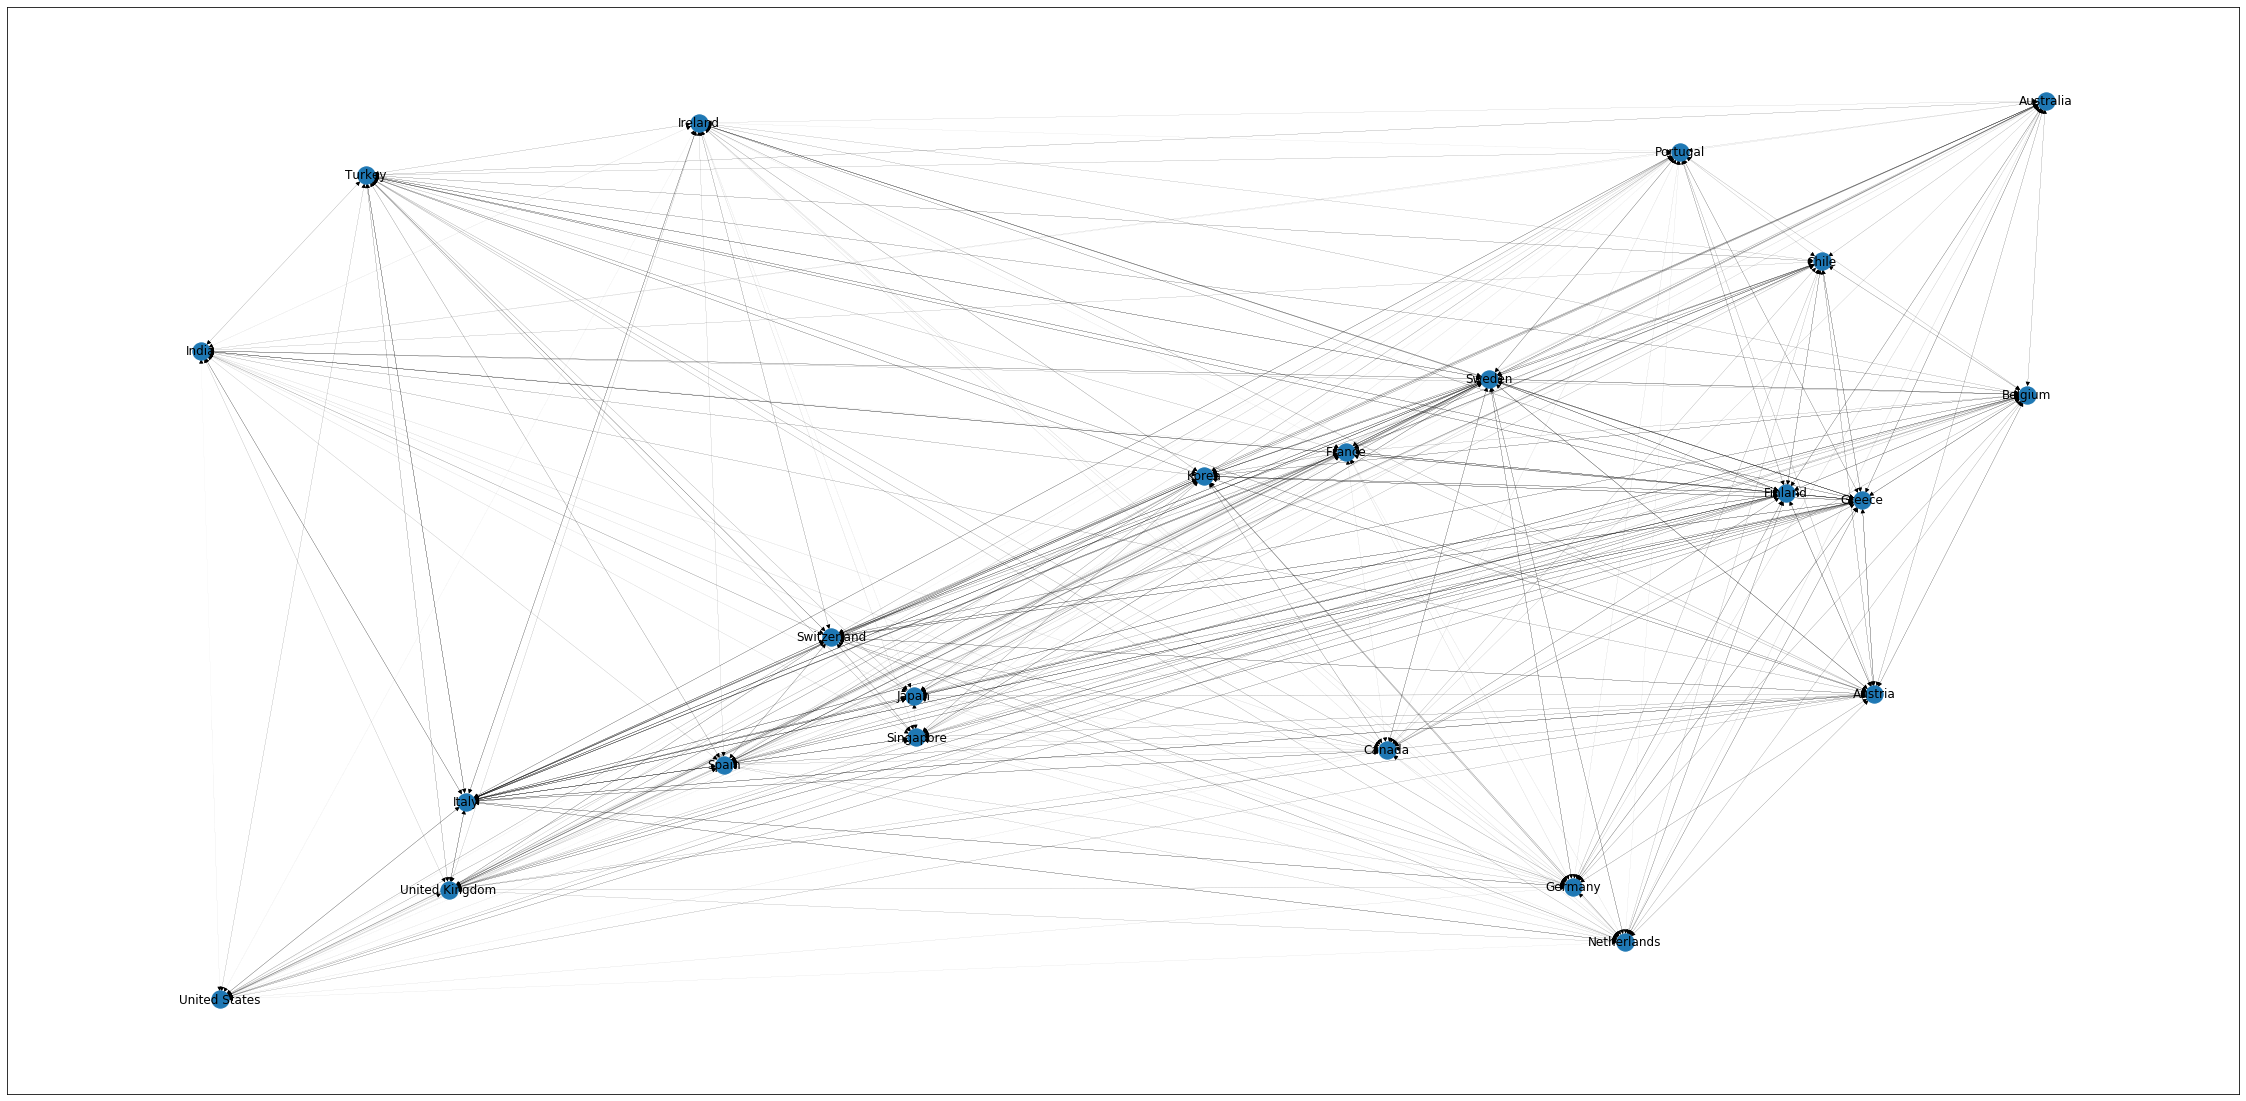

In [72]:
DG = nx.MultiDiGraph()

for i in range(len(countries)):
    DG.add_node(countries[i], gammas_nx = final_df['gammas'][i], betas_nx = final_df['betas'][i])
    
for i in range(len(countries)):
    for j in range(len(countries)):
        if i!=j:
            DG.add_edge(countries[i],countries[j], weights=final_df['Inverse score'][i])
            DG.add_edge(countries[j],countries[i], weights=final_df['Inverse score'][i])
            
            
edgewidth_DG = [d['weights'] for (u,v,d) in DG.edges(data=True)]

# layout
#pos = nx.spring_layout(G, iterations=50)
pos = nx.random_layout(DG)

# rendering
plt.figure(figsize=(40,20))
nx.draw_networkx_nodes(DG, pos)
nx.draw_networkx_edges(DG, pos, width=edgewidth_DG)
nx.draw_networkx_labels(DG,pos)  


Some Comments:
- The network cannot be displayed with two edges (and respective weights) per pair of countries. So it doesn't make sense to display just double arrows without a differentiation element
- The EoN library (at least, the function for the SIR model) doesn't seem to accept directed graphs, so we might think about an alternative way to employ this directed graph